# Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import os
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# The answer to life, the universe, and everything is 42

In [2]:
import torch
import numpy as np
import random

# Set random seed for reproducibility
seed = 42

# Set the seed for all random number generators
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# For CUDA (if using GPU)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If you are using multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False     # May slow down training but ensures reproducibility

# Create the transforms using torchvision

In [3]:
# Define data transformations
data_transforms = {
    'Training': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create the dataloader using torchvision

In [4]:
# Specify the paths
data_dir = 'cleaned'

# Load datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['Training', 'Testing']}

# Define dataloaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
               for x in ['Training', 'Testing']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Testing']}
class_names = image_datasets['Training'].classes
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


# Here, you define the model size

In [5]:
from model import ResNet

# depth Parameter: Specifies the depth of the ResNet model (e.g., 18, 34, 50, 101, 152).

depth = 101
num_classes = 4

# Create a ResNet-50 model
model = ResNet(depth=depth, num_classes=num_classes)

model_name = "ResNet-{}".format(depth) + "_TumorClassification"

# The model architecture

In [6]:
from torchsummary import summary

# Assuming your model is already defined and moved to the appropriate device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Use the 'device' argument in summary as a string, either 'cuda' or 'cpu'
summary(model, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

# Create optimiser and StepLR

In [7]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Use Adam optimizer with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [8]:
import time
import torch
import torch.nn.functional as F
import os
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs=25, patience=5, log_dir="logs", file_name="training_metrics"):
    # Create a directory for logs if it doesn't exist
    os.makedirs(log_dir, exist_ok=True)
    
    # Define the file paths based on the user-defined file name
    log_file_path = os.path.join(log_dir, f"{file_name}_log.txt")
    metrics_file_path = os.path.join(log_dir, f"{file_name}_metrics.xlsx")
    
    # Initialize logging file
    with open(log_file_path, "w") as log_file:
        log_file.write("Epoch, Phase, Loss, Accuracy, Precision, Recall, F1-Score\n")
    
    # For metrics storage
    metrics_data = {"Epoch": [], "Phase": [], "Loss": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-Score": []}

    since = time.time()

    best_model_wts = model.state_dict()
    best_loss = float('inf')  # Initialize the best loss to infinity
    best_acc = 0.0
    epochs_no_improve = 0  # Counter for early stopping

    for epoch in range(num_epochs):
        
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['Training', 'Testing']:
            if phase == 'Training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize only in training phase
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                # Collect predictions and labels for precision, recall, and F1
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'Training':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Calculate precision, recall, and F1-score
            precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
            recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
            f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1-Score: {f1:.4f}')

            # Log the metrics
            with open(log_file_path, "a") as log_file:
                log_file.write(f"{epoch}, {phase}, {epoch_loss:.4f}, {epoch_acc:.4f}, {precision:.4f}, {recall:.4f}, {f1:.4f}\n")

            # Store metrics for later saving to Excel
            metrics_data['Epoch'].append(epoch)
            metrics_data['Phase'].append(phase)
            metrics_data['Loss'].append(epoch_loss)
            metrics_data['Accuracy'].append(epoch_acc.item())
            metrics_data['Precision'].append(precision)
            metrics_data['Recall'].append(recall)
            metrics_data['F1-Score'].append(f1)

            # Check for improvement in the testing phase
            if phase == 'Testing':
                if epoch_loss < best_loss:  # If there's an improvement in testing loss
                    best_loss = epoch_loss
                    best_model_wts = model.state_dict()  # Save the best weights
                    best_acc = epoch_acc
                    epochs_no_improve = 0  # Reset counter if there is improvement
                else:
                    epochs_no_improve += 1  # Increment counter if no improvement

                # Early stopping condition
                if epochs_no_improve >= patience:
                    print(f"Early stopping after {epochs_no_improve} epochs with no improvement.")
                    model.load_state_dict(best_model_wts)  # Restore the best model weights
                    # Save metrics to Excel file
                    df_metrics = pd.DataFrame(metrics_data)
                    df_metrics.to_excel(metrics_file_path, index=False)
                    return model

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Testing Loss: {best_loss:.4f}, Best Testing Acc: {best_acc:.4f}')

    # Load the best model weights after training is complete
    model.load_state_dict(best_model_wts)
    
    # Save metrics to Excel file
    df_metrics = pd.DataFrame(metrics_data)
    df_metrics.to_excel(metrics_file_path, index=False)

    return model

In [9]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, dataloaders, dataset_sizes, device, num_epochs=25, patience=5, log_dir=model_name + "logs", file_name=model_name + "experiment_1")

Epoch 1/25
----------


Training Loss: 0.9627 Acc: 0.6140 Precision: 0.6134 Recall: 0.6140 F1-Score: 0.6124
Testing Loss: 1.6859 Acc: 0.5278 Precision: 0.6598 Recall: 0.5278 F1-Score: 0.4771
Epoch 2/25
----------
Training Loss: 0.6117 Acc: 0.7701 Precision: 0.7695 Recall: 0.7701 F1-Score: 0.7697
Testing Loss: 0.9061 Acc: 0.7361 Precision: 0.7501 Recall: 0.7361 F1-Score: 0.7097
Epoch 3/25
----------
Training Loss: 0.5017 Acc: 0.8174 Precision: 0.8176 Recall: 0.8174 F1-Score: 0.8172
Testing Loss: 1.4535 Acc: 0.6003 Precision: 0.6878 Recall: 0.6003 F1-Score: 0.5397
Epoch 4/25
----------
Training Loss: 0.4424 Acc: 0.8398 Precision: 0.8401 Recall: 0.8398 F1-Score: 0.8396
Testing Loss: 1.4843 Acc: 0.6178 Precision: 0.7147 Recall: 0.6178 F1-Score: 0.5370
Epoch 5/25
----------
Training Loss: 0.3677 Acc: 0.8703 Precision: 0.8700 Recall: 0.8703 F1-Score: 0.8699
Testing Loss: 0.6842 Acc: 0.7040 Precision: 0.7503 Recall: 0.7040 F1-Score: 0.7077
Epoch 6/25
----------
Training Loss: 0.3276 Acc: 0.8831 Precision: 0.8824 Rec

# Evaluation

In [10]:
# Get predictions on test data
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['Testing']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print(conf_matrix)

              precision    recall  f1-score   support

      glioma       0.99      0.96      0.98       300
  meningioma       0.97      0.98      0.98       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311

[[289   6   1   4]
 [  2 301   2   1]
 [  0   0 405   0]
 [  0   2   0 298]]


# Confusion plot

              precision    recall  f1-score   support

      glioma       0.99      0.96      0.98       300
  meningioma       0.97      0.98      0.98       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



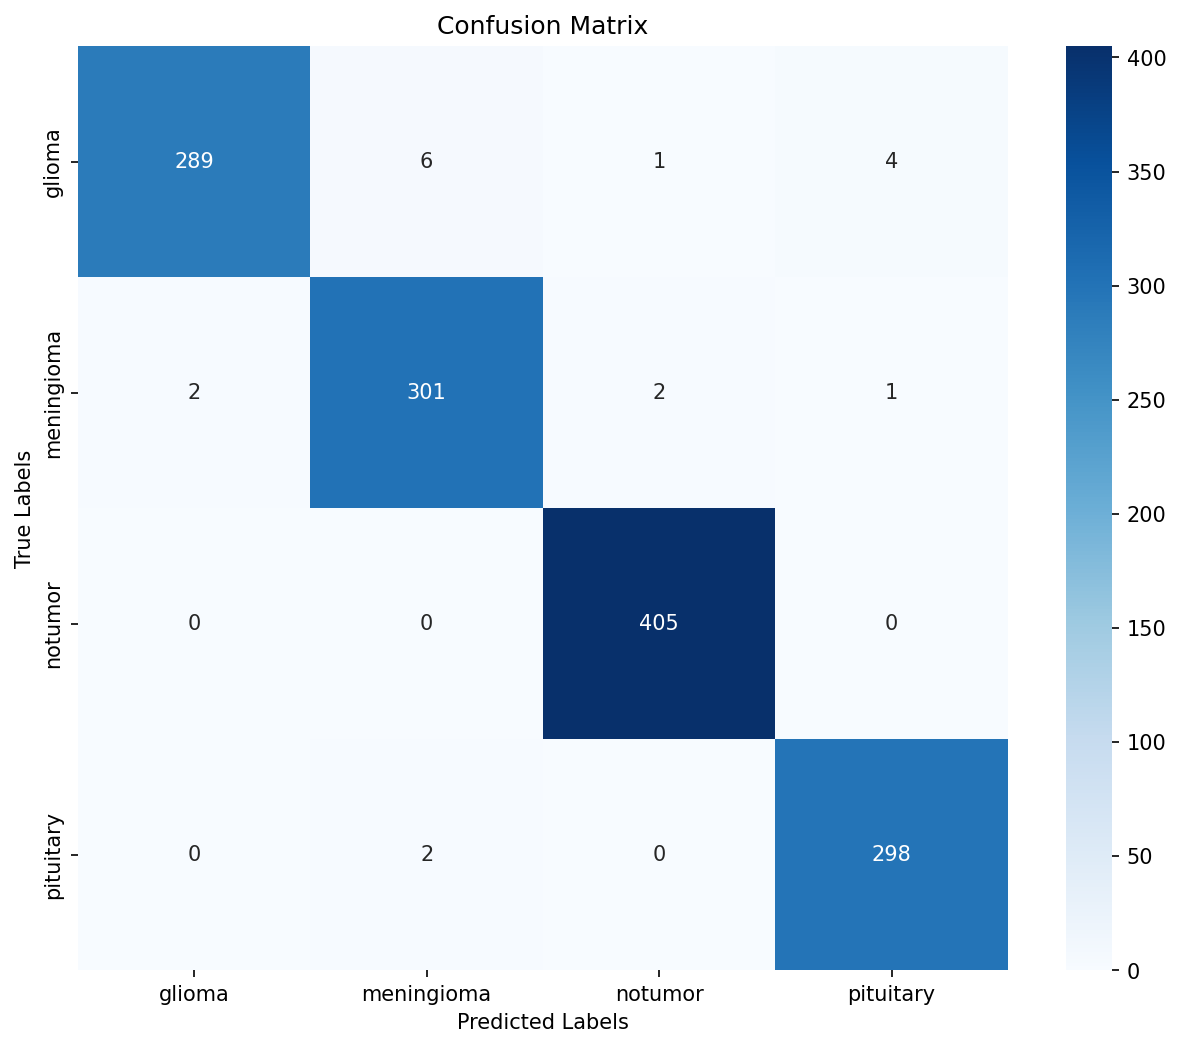

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions on test data
model.eval()
all_preds = []
all_labels = []
all_inputs = []

with torch.no_grad():
    for inputs, labels in dataloaders['Testing']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_inputs.extend(inputs.cpu().numpy())  # Keep the inputs for visualization

# Classification Report
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8), dpi=150)  # High resolution plot
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Sample plot

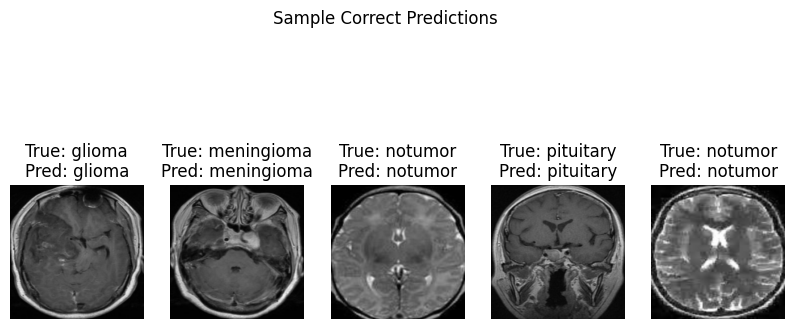

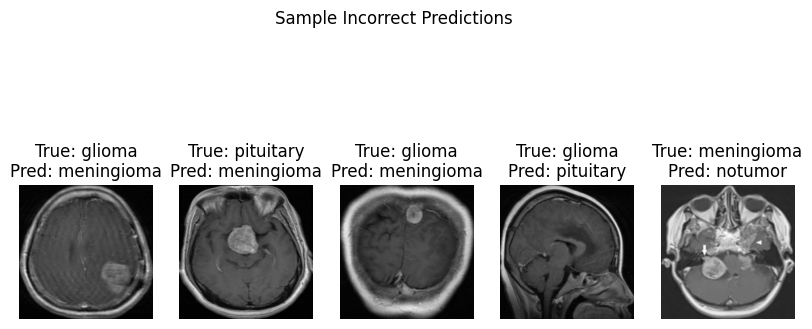

In [12]:
# Find correct and incorrect predictions
correct_preds = []
incorrect_preds = []

for i in range(len(all_labels)):
    if all_preds[i] == all_labels[i]:
        correct_preds.append((all_inputs[i], all_labels[i], all_preds[i]))
    else:
        incorrect_preds.append((all_inputs[i], all_labels[i], all_preds[i]))

# Visualize a few correct predictions
def show_samples(samples, title):
    plt.figure(figsize=(10, 5))
    for idx, (image, true_label, pred_label) in enumerate(samples[:5]):
        image = np.transpose(image, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        image = np.clip(image, 0, 1)  # Normalize to [0, 1] range for visualization

        plt.subplot(1, 5, idx+1)
        plt.imshow(image)
        plt.title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display correct predictions
show_samples(correct_preds, title="Sample Correct Predictions")

# Display incorrect predictions
show_samples(incorrect_preds, title="Sample Incorrect Predictions")